## Measure time to render.

Some ideas for benchmarking variuos timings. TODO: measure scene compute time.

In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt

import time

import numpy as np
from plotoptix import NpOptiX

Initial setup for the raytracer:

In [2]:
width = 800
height = 500

rt = NpOptiX(width=width, height=height, start_now=False)

Setup the scene as you like.

Read the mesh...

In [3]:
# flat shading - fastest, only one ray/pixel (the one from the camera), no secondary rays
#from plotoptix.materials import m_flat
#rt.setup_material("flat", m_flat)
#rt.load_mesh_obj("data/utah-teapot.obj", mat="flat")

# the default diffuse material: 1-3 rays/pixel from the camera, plus secondary rays
rt.load_mesh_obj("data/utah-teapot.obj", c=0.92)

...or add generated data, or do both.

In [4]:
#n = 500
#xyz = np.random.random((n, 3))
#r = 5 * np.random.random(n) + 0.1
#for i in range(n): xyz[i] = 5 * r[i] * xyz[i] / np.linalg.norm(xyz[i])
    
#rt.set_data("plot", pos=xyz, r=0.5*r)

Setup camera and lights:

In [5]:
rt.setup_camera("cam1", cam_type="ThinLens",
                eye=[20, 40, 100],
                target=[0, 0, 0],
                up=[0.0, 1.0, 0.0],
                fov=23)

rt.setup_area_light("light1", center=[80, 40, 80], target=[0, 0, 0], u=20, v=30, color=[23, 21, 17])

rt.set_ambient([0.01, 0.1, 0.25])
rt.set_background(0)

A place to keep the benchmark state and results:

In [6]:
class Results():
    frame_time = 0  # start time of each accumulation pass
    image_time = 0  # start time of the whole accumulation process
    
    nf_history = 500
    frame_time_hist = np.zeros(nf_history, dtype=np.float32)
    xf_axis_hist = np.array(range(nf_history), dtype=np.float32)
    ni_history = 50
    image_time_hist = np.zeros(ni_history, dtype=np.float32)
    xi_axis_hist = np.array(range(ni_history), dtype=np.float32)
    
    frame_idx = 0    # current measurement index
    image_idx = 0
    
    acc_started = False
    def start_rt():
        if not Results.acc_started: # update time of the frame 0 start
            t = time.perf_counter() # (note: frame 0 timing is only approximated)
            Results.frame_time = t
            Results.image_time = t
    
    def count_frame():
        t = time.perf_counter()
        Results.frame_time_hist[Results.frame_idx] = t - Results.frame_time
        Results.frame_time = t
        Results.frame_idx = (Results.frame_idx + 1) % Results.nf_history
        Results.acc_started = True

    def count_image():
        t = time.perf_counter()
        Results.image_time_hist[Results.image_idx] = t - Results.image_time
        Results.image_idx = (Results.image_idx + 1) % Results.ni_history
        Results.acc_started = False

Setup callbacks.

**NOTE:** Image and history plot updates can dominate the time measurement if enabled on each frame launch; it is more accurate to refresh figures in the accum_done callback, though you may have to wait for a while before update occurs.

In [7]:
def start_image(rt: NpOptiX): Results.start_rt()
def image_completed(rt: NpOptiX):
    Results.count_image()
    
    frame_plot.set_ydata(Results.frame_time_hist)
    image_plot.set_ydata(Results.image_time_hist)
    img.set_data(rt._img_rgba) # update image data
    plt.draw()                 # refresh figure

def update_image(rt: NpOptiX):
    Results.count_frame()
    
    # enable to include the image refresh time
    #img.set_data(rt._img_rgba)
    #plt.draw()

In [8]:
rt.set_rt_starting_cb(start_image)
rt.set_launch_finished_cb(update_image)
rt.set_accum_done_cb(image_completed)

Show the output image here:

<IPython.core.display.Javascript object>


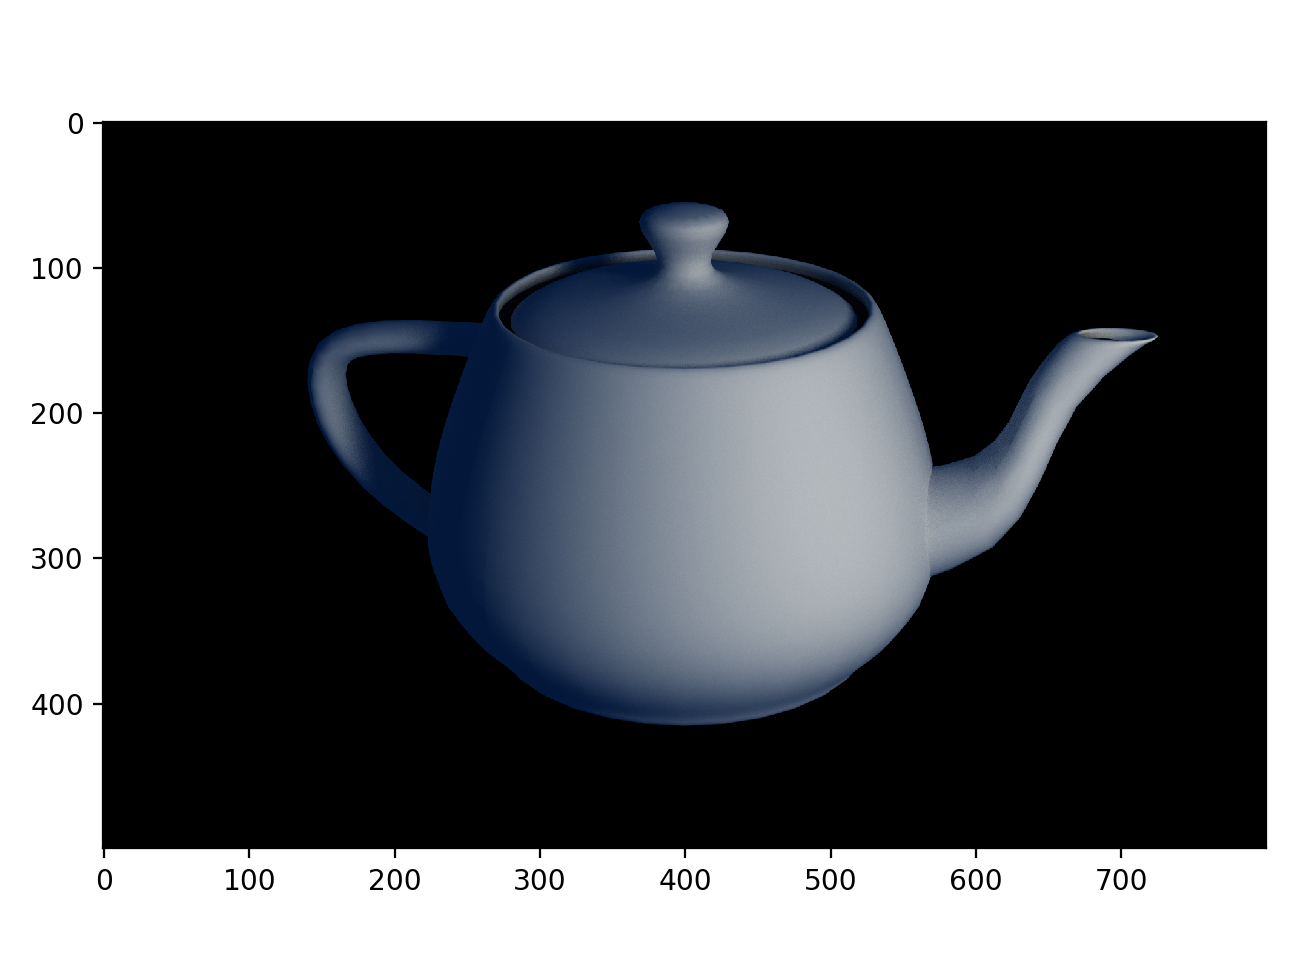

In [9]:
plt.figure(1)
img = plt.imshow(np.zeros((height,width,4)), cmap=plt.get_cmap("flag"))
plt.tight_layout()

<IPython.core.display.Javascript object>


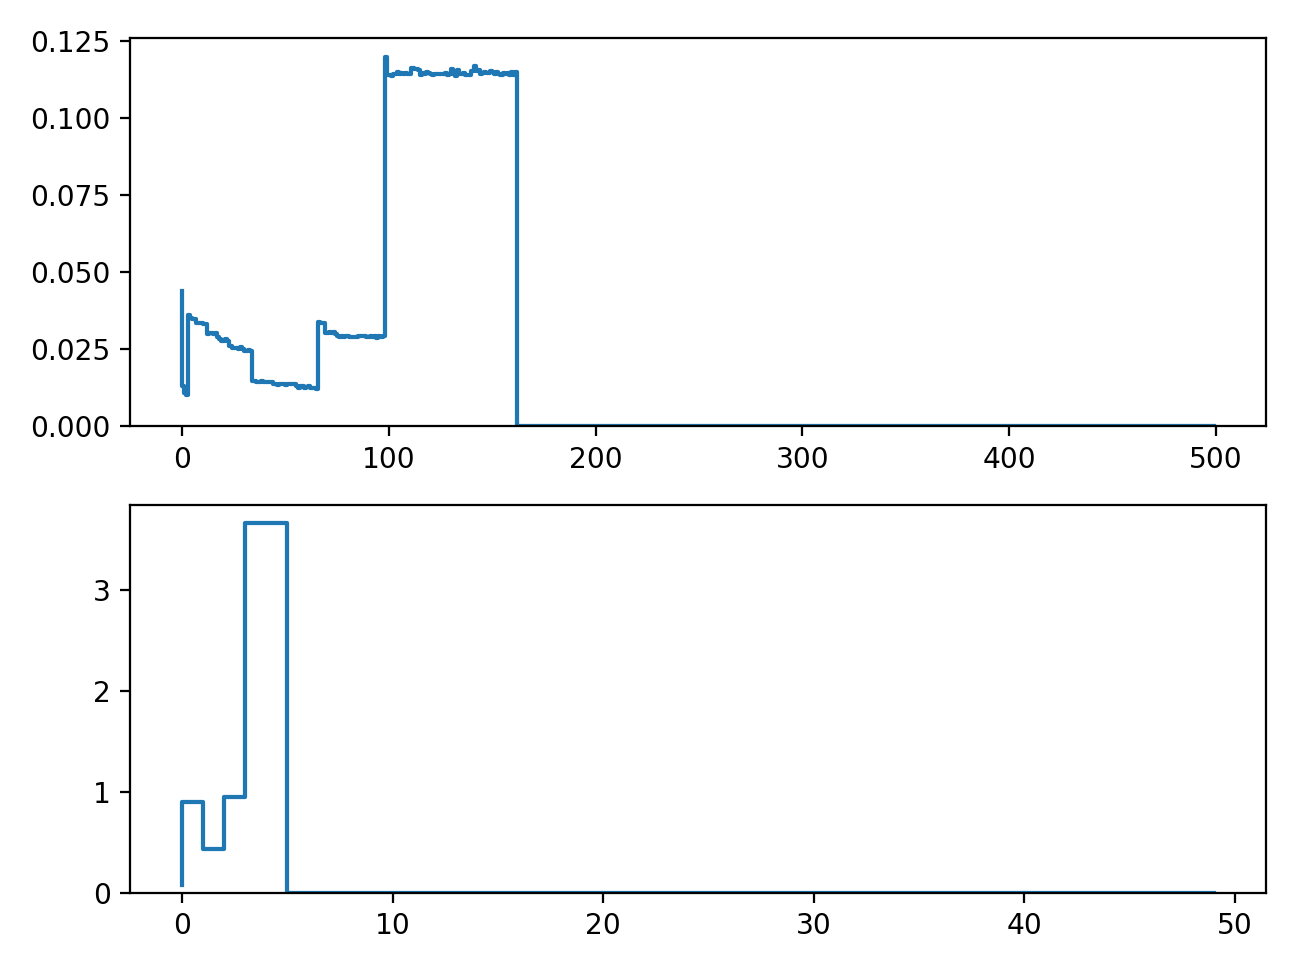

In [16]:
fig, (ax1, ax2) = plt.subplots(2, 1, num=2)
frame_plot = ax1.step(Results.xf_axis_hist, Results.frame_time_hist)[0]
image_plot = ax2.step(Results.xi_axis_hist, Results.image_time_hist)[0]
ax1.set_ylim([0, None])
ax2.set_ylim([0, None])
plt.tight_layout()

Start the ray tracing:

In [11]:
rt.start()

Set the number of accumulation passes per each image refresh and the total number of passes (defaults are 1, 4).

In [12]:
rt.set_param(min_accumulation_step=4, max_accumulation_frames=128)

Change something in the scene and refresh if needed.

In [14]:
rt.update_camera("cam1", fov=60)

In [15]:
rt.resize(1920, 1080)

In [17]:
rt.refresh_scene()

Close the ray-tracer.

In [18]:
rt.close()